In [1]:
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
from urllib.parse import quote
import json
import aiohttp
import asyncio

In [2]:
import pandas as pd
import endpoints
from datetime import datetime, timedelta

import time
import numpy as np
import requests
import json
from urllib.parse import quote
import os

pd.set_option("display.max_columns", None)

In [3]:
season_ratio = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/season_ratio.csv')

In [4]:
info_subjects = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/info_subjects-2.csv')

In [5]:
season_ratio

,date,coefficient,subject_id
0,2025-01-01T00:00:00+00:00,1.331179,390
1,2025-01-02T00:00:00+00:00,1.396464,390
2,2025-01-03T00:00:00+00:00,1.222846,390
3,2025-01-04T00:00:00+00:00,1.208240,390
4,2025-01-05T00:00:00+00:00,1.169379,390
...,...,...,...
452726,2025-12-27T00:00:00+00:00,1.223481,6728
452727,2025-12-28T00:00:00+00:00,1.364269,6728
452728,2025-12-29T00:00:00+00:00,1.306579,6728
452729,2025-12-30T00:00:00+00:00,1.216398,6728


In [8]:
info_subjects = info_subjects[['name', 'subjectId']]
info_subjects[['name', 'subject_id']] = info_subjects[['name', 'subjectId']]

In [9]:
season = pd.merge(info_subjects, season_ratio, how='left', on=['subject_id'])

In [11]:
season = season[season['date'].notnull()]

In [12]:
season

,name,subjectId,subject_id,date,coefficient
2,Брюки,11,11,2025-01-01T00:00:00+00:00,0.649700
3,Брюки,11,11,2025-01-02T00:00:00+00:00,0.840972
4,Брюки,11,11,2025-01-03T00:00:00+00:00,0.770098
5,Брюки,11,11,2025-01-04T00:00:00+00:00,0.862680
6,Брюки,11,11,2025-01-05T00:00:00+00:00,0.912966
...,...,...,...,...,...
455531,Бассейны каркасные,8417,8417,2025-12-27T00:00:00+00:00,0.261675
455532,Бассейны каркасные,8417,8417,2025-12-28T00:00:00+00:00,0.204264
455533,Бассейны каркасные,8417,8417,2025-12-29T00:00:00+00:00,0.221339
455534,Бассейны каркасные,8417,8417,2025-12-30T00:00:00+00:00,0.179951


In [ ]:
len(season['name'].unique())


1229

In [14]:
df = season

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

/var/folders/5g/fwv1f3fn18z1rs_1psc_npvr0000gn/T/ipykernel_69653/1813318350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date']).dt.date


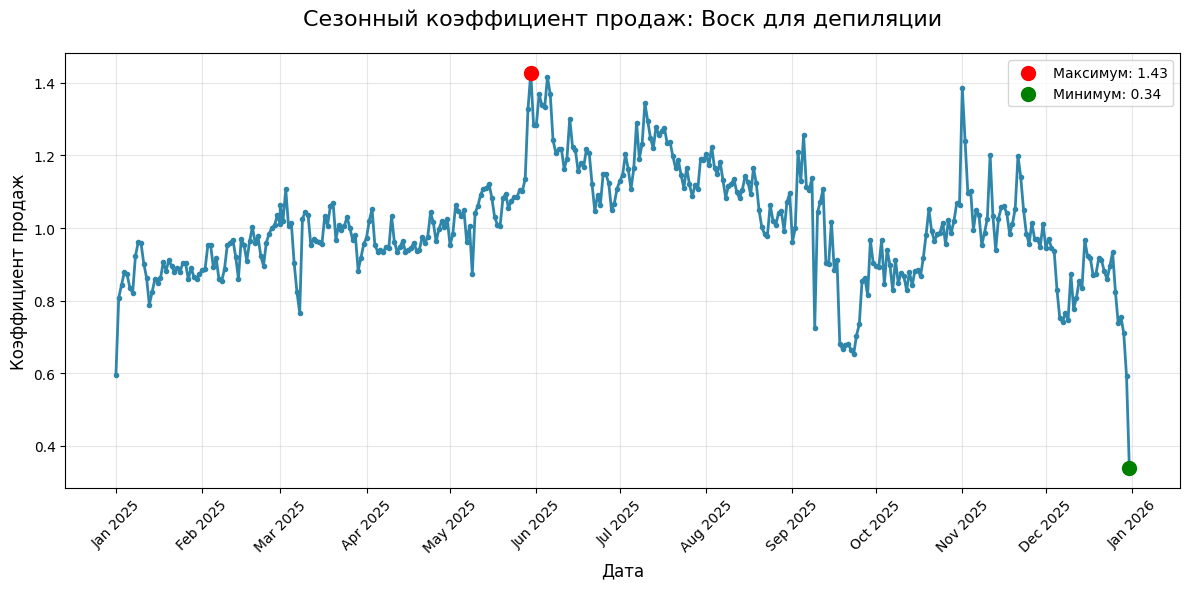

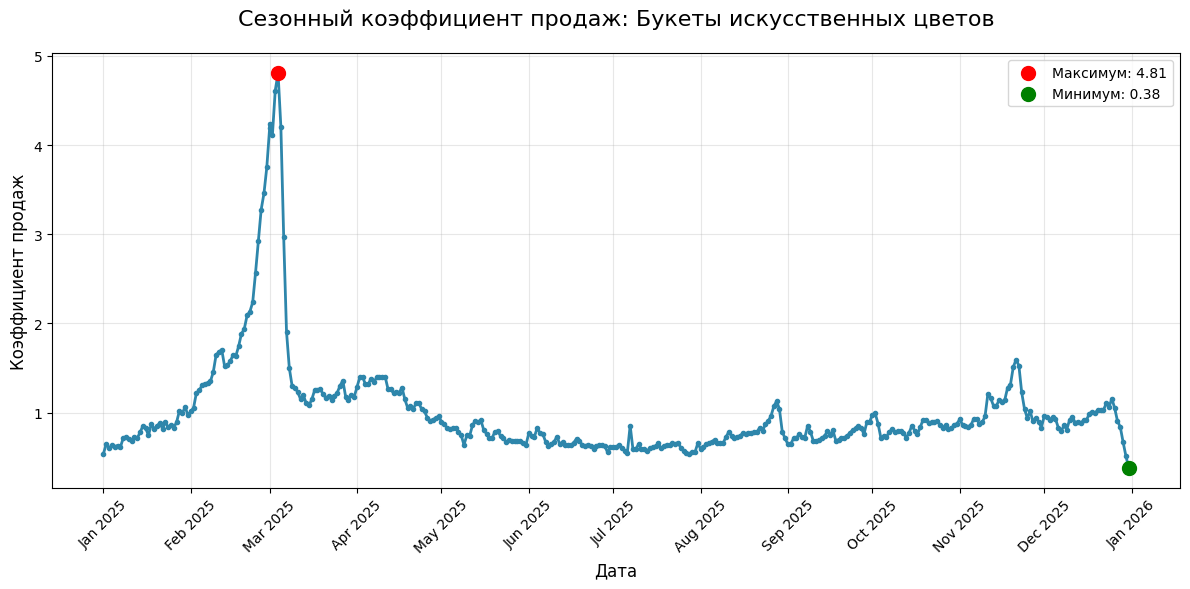

In [ ]:
df['date'] = pd.to_datetime(df['date']).dt.date
figsize=(12, 6)

selected_names = [
    "Воск для депиляции",
    "Букеты искусственных цветов",   # если есть (аналогично)
]

# Группируем по названию категории
for name in selected_names:
    subset = df[df['name'] == name]

    if subset.empty:
        print(f"Предупреждение: Категория '{name}' не найдена в данных.")
        continue

    # Сортируем по дате
    subset = subset.sort_values('date')

    dates = subset['date']
    coeffs = subset['coefficient']

    plt.figure(figsize=figsize)
    plt.plot(dates, coeffs, marker='o', linewidth=2, markersize=3, color='#2E86AB')

    plt.title(f"Сезонный коэффициент продаж: {name}", fontsize=16, pad=20)
    plt.xlabel("Дата", fontsize=12)
    plt.ylabel("Коэффициент продаж", fontsize=12)
    plt.grid(True, alpha=0.3)

    # Красивые подписи месяцев на оси X
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))
    plt.xticks(rotation=45)

    # Подсвечиваем пики и минимумы
    max_idx = coeffs.idxmax()
    min_idx = coeffs.idxmin()
    plt.scatter(subset.loc[max_idx, 'date'], coeffs.max(), color='red', s=100, zorder=5, label=f"Максимум: {coeffs.max():.2f}")
    plt.scatter(subset.loc[min_idx, 'date'], coeffs.min(), color='green', s=100, zorder=5, label=f"Минимум: {coeffs.min():.2f}")
    plt.legend()

    plt.tight_layout()

    plt.show()
    plt.close()

In [13]:
season.to_csv('season_ratio.csv')

In [8]:
def get_cookies_local(email: str, password: str) -> dict:
    """getting cookies"""

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get('https://eggheads.solutions/fe3/login')

    time.sleep(2)
    try:
        email_field = driver.find_element(By.NAME, 'email')
        password_field = driver.find_element(By.NAME, 'password')
        email_field.send_keys(email)
        password_field.send_keys(password)

        login_button = driver.find_element(By.CLASS_NAME, 'authorization-button')
        login_button.click()

        time.sleep(3)

        cookies = driver.get_cookies()
        driver.quit()

        cookies = {cookie['name']: cookie['value'] for cookie in cookies}

    except Exception as e:
        print(f"Ошибка: {e}")
        driver.quit()

    return cookies

In [12]:
get_cookies_local(SITE_EMAIL, SITE_PASSWORD)

{'ph_phc_RjQVzgGzKtCqDUe9sIM4DITPFgmusuwPvZWbTC4SdBV_posthog': '%7B%22distinct_id%22%3A%2266822%22%2C%22%24sesid%22%3A%5B1766065463746%2C%22019b31b4-4b72-7485-99d4-052366bc3ed7%22%2C1766065458034%5D%2C%22%24epp%22%3Atrue%7D',
 'tmr_detect': '0%7C1766065462720',
 'eh-user-id': '66822',
 'CAKEPHP': '82471f9d28e660b205d253c18799840b',
 'previousUrl': 'eggheads.solutions%2Fdocs-login-news',
 '_ym_d': '1766065458',
 'tmr_lvidTS': '1766065460441',
 '_ym_uid': '1766065458821855546',
 'tildasid': '1766065460366.269649',
 'tildauid': '1766065460366.375427',
 '_ga_DDWEZTWGJS': 'GS2.2.s1766065458$o1$g1$t1766065460$j58$l0$h1152051816',
 'tmr_lvid': 'cb2a50d9fea1182be63e32f506e46a73',
 'roistat_is_save_data_in_cookie': '1',
 '___dc': '201f4010-a077-4b07-bc05-8cb19c531493',
 'roistat_is_need_listen_requests': '0',
 'domain_sid': 'QUizV2qrOJoLqNfv4SvlJ%3A1766065460877',
 '_ym_isad': '2',
 'roistat_first_visit': '2637915',
 'CookieAuth3': '%5B%22vnaumovich123%40gmail.com%22%2C%22%242y%2410%24XObjgfbPx

In [ ]:
import pandas as pd

# Загружаем данные из CSV файлов
info_subjects = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/info_subjects-2.csv')
season_ratio = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/season_ratio.csv')

# Эквивалент CTE (WITH info AS ...) и LEFT JOIN
# Сначала создаем "info" DataFrame как в CTE
info = info_subjects[['subjectId', 'name']].copy().rename(columns={'subjectId': 'subject_id'})

# Выполняем LEFT JOIN между info и season_ratio
# Используем merge с параметром how='left'
result = pd.merge(
    info,
    season_ratio,
    left_on='subject_id',
    right_on='subject_id',  # В вашем SQL был info.subject_id = info.subject_id, вероятно опечатка
    how='left'
)

# Если в SQL на самом деле должно быть info.subject_id = season_ratio.subject_id:
# result = pd.merge(
#     info,
#     season_ratio,
#     left_on='subject_id',
#     right_on='subject_id',  # предполагая, что в season_ratio есть колонка subject_id
#     how='left'
# )

# Если нужно переименовать колонки как в SELECT
result = result[['subject_id', 'name', 'date', 'coefficient']]

# Выводим результат


        subject_id                                name  \
0                2                               Обувь   
1                7                             Игрушки   
2               11                               Брюки   
3               11                               Брюки   
4               11                               Брюки   
...            ...                                 ...   
455580        8470                          Картины 3D   
455581        8471                  Ванны для груминга   
455582        8472  Вентиляционно-осушительные коробки   
455583        8473        Шторки стеклянные для ванной   
455584        8474            Комплектующие для жалюзи   

                             date  coefficient  
0                             NaN          NaN  
1                             NaN          NaN  
2       2025-01-01T00:00:00+00:00     0.649700  
3       2025-01-02T00:00:00+00:00     0.840972  
4       2025-01-03T00:00:00+00:00     0.770098  
...      

In [14]:
info_subjects = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/info_subjects-2.csv')
season_ratio = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/season_ratio.csv')


In [15]:
season_ratio_2 = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/season_ratio_2025-12-01.csv')

In [18]:
season_ratio_2

,date,coefficient,subject_id
0,2025-01-01T00:00:00+00:00,0.665974,11
1,2025-01-02T00:00:00+00:00,0.859046,11
2,2025-01-03T00:00:00+00:00,0.783723,11
3,2025-01-04T00:00:00+00:00,0.880258,11
4,2025-01-05T00:00:00+00:00,0.933085,11
...,...,...,...
456726,2025-12-27T00:00:00+00:00,0.257937,8417
456727,2025-12-28T00:00:00+00:00,0.201348,8417
456728,2025-12-29T00:00:00+00:00,0.222953,8417
456729,2025-12-30T00:00:00+00:00,0.178141,8417


In [17]:
season_ratio

,date,coefficient,subject_id
0,2025-01-01T00:00:00+00:00,1.331179,390
1,2025-01-02T00:00:00+00:00,1.396464,390
2,2025-01-03T00:00:00+00:00,1.222846,390
3,2025-01-04T00:00:00+00:00,1.208240,390
4,2025-01-05T00:00:00+00:00,1.169379,390
...,...,...,...
452726,2025-12-27T00:00:00+00:00,1.223481,6728
452727,2025-12-28T00:00:00+00:00,1.364269,6728
452728,2025-12-29T00:00:00+00:00,1.306579,6728
452729,2025-12-30T00:00:00+00:00,1.216398,6728


In [10]:
info_subjects

,subjectId,totalItems,diffTotalItems,totalSizes,diffTotalSizes,rating,diffRating,position,diffPosition,diffOrders,diffOrdersSum,ordersPeriodSum,name,isFavorite,orders,ordersSum,loosesPercent,avgSum,loosesSum,orderedCardsCountPercent,groupAOrderedCardsCountPercent
0,2,0,-3,0,-3,0,0.00,4294967295,7171,0,0,0,Обувь,False,0,0,0.00,0,0,0.00,0.00
1,7,0,-42,0,-42,0,0.00,4294967295,7034,0,0,4764,Игрушки,False,0,0,NaN,1588,0,4.76,2.38
2,11,0,-282712,0,-1006537,0,-945764.34,4294967295,9,-1397,-7888147,21556557519,Брюки,False,474871,821137332,37.32,1826,8045587930,53.40,5.94
3,24,0,-90631,0,-192975,0,-77024.32,4294967295,584,-2191,-647597,371758967,Кольца,False,29468,11617343,21.89,458,81387215,34.14,5.13
4,27,0,-81790,0,-81790,0,-143810.83,4294967295,259,-117,-254908,134241811,Шкатулки,False,4232,3468907,25.87,920,34731311,6.18,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,8470,0,-4659,0,-4659,0,-6121.83,4294967295,3508,16,26265,437603,Картины 3D,False,27,31687,52.00,1004,227545,2.34,0.62
6996,8471,0,-38,0,-38,0,-52.89,4294967295,6766,0,0,0,Ванны для груминга,False,0,0,0.00,0,0,0.00,0.00
6997,8472,0,-93,0,-93,0,-390.33,4294967295,6193,0,0,34178,Вентиляционно-осушительные коробки,False,0,0,52.82,1320,18054,11.65,4.84
6998,8473,0,-1214,0,-1214,0,-3566.90,4294967295,4221,3,10770,2356962,Шторки стеклянные для ванной,False,4,10965,25.52,6339,601476,3.80,0.48


In [33]:
result[result['subject_id'] == 11]

,subject_id,name,date,coefficient
2,11,Брюки,2025-01-01T00:00:00+00:00,0.649700
3,11,Брюки,2025-01-02T00:00:00+00:00,0.840972
4,11,Брюки,2025-01-03T00:00:00+00:00,0.770098
5,11,Брюки,2025-01-04T00:00:00+00:00,0.862680
6,11,Брюки,2025-01-05T00:00:00+00:00,0.912966
...,...,...,...,...
363,11,Брюки,2025-12-27T00:00:00+00:00,0.646779
364,11,Брюки,2025-12-28T00:00:00+00:00,0.606810
365,11,Брюки,2025-12-29T00:00:00+00:00,0.557269
366,11,Брюки,2025-12-30T00:00:00+00:00,0.467876


In [30]:
len(result[result['coefficient'].notnull()]['subject_id'].unique())

1229

In [31]:
len(info_subjects['subjectId'].unique())

7000

In [32]:
len(season_ratio['subject_id'].unique())

1237

In [26]:
season_ratio

,date,coefficient,subject_id
0,2025-01-01T00:00:00+00:00,1.331179,390
1,2025-01-02T00:00:00+00:00,1.396464,390
2,2025-01-03T00:00:00+00:00,1.222846,390
3,2025-01-04T00:00:00+00:00,1.208240,390
4,2025-01-05T00:00:00+00:00,1.169379,390
...,...,...,...
452726,2025-12-27T00:00:00+00:00,1.223481,6728
452727,2025-12-28T00:00:00+00:00,1.364269,6728
452728,2025-12-29T00:00:00+00:00,1.306579,6728
452729,2025-12-30T00:00:00+00:00,1.216398,6728


In [25]:
season_ratio[season_ratio['subject_id'] == 2]

,date,coefficient,subject_id


In [18]:
info_subjects['subjectId'].unique()[0]

2

In [8]:
result.reset_index(drop=True)

,subject_id,name,date,coefficient
0,2,Обувь,NaN,NaN
1,7,Игрушки,NaN,NaN
2,11,Брюки,2025-01-01T00:00:00+00:00,0.649700
3,11,Брюки,2025-01-02T00:00:00+00:00,0.840972
4,11,Брюки,2025-01-03T00:00:00+00:00,0.770098
...,...,...,...,...
455580,8470,Картины 3D,NaN,NaN
455581,8471,Ванны для груминга,NaN,NaN
455582,8472,Вентиляционно-осушительные коробки,NaN,NaN
455583,8473,Шторки стеклянные для ванной,NaN,NaN


In [27]:


url = "https://api-endpoint.mta.info/Dataservice/mtagtfsfeeds/nyct%2Fgtfs-ace"


response = requests.get(url)

if response.status_code == 200:
    # Данные в формате protobuf, нужно декодировать
    print("Данные получены успешно")
    print(f"Размер данных: {len(response.content)} байт")
else:
    print(f"Ошибка: {response.status_code}")

Данные получены успешно
Размер данных: 110940 байт


In [38]:
from google.transit import gtfs_realtime_pb2

In [ ]:
import pandas as pd
from google.transit import gtfs_realtime_pb2

feed = gtfs_realtime_pb2.FeedMessage()
feed.ParseFromString(response.content)

vehicle_data = []

for entity in feed.entity:
    if entity.HasField('vehicle'):
        vehicle = entity.vehicle
        vehicle_info = {
            # Идентификация
            'vehicle_id': vehicle.vehicle.id,
            'trip_id': vehicle.trip.trip_id,
            'route_id': vehicle.trip.route_id,  # A, C, E линии
            'direction_id': vehicle.trip.direction_id,  # 0=север, 1=юг

            # ⭐️ ГЕОЛОКАЦИЯ ⭐️
            'latitude': vehicle.position.latitude,   # Широта  ✅ ИСПРАВЛЕНО
            'longitude': vehicle.position.longitude,  # Долгота ✅ ИСПРАВЛЕНО
            'bearing': vehicle.position.bearing,  # Направление (0-360°)
            'speed': vehicle.position.speed,    # Скорость (м/с)

            # Время
            'timestamp': vehicle.timestamp,     # Время обновления
            'current_status': vehicle.current_status  # Состояние
        }
        vehicle_data.append(vehicle_info)

df_vehicles = pd.DataFrame(vehicle_data)


In [ ]:
import requests
import pandas as pd
import time
import json
from datetime import datetime

def get_flightradar_data():
    """Данные из FlightRadar24"""
    try:
        # Получаем данные через их публичный API
        url = "https://data-live.flightradar24.com/zones/fcgi/feed.js"
        params = {
            'bounds': '30,70,-20,50',  # Европа
            'faa': '1',
            'satellite': '1',
            'mlat': '1',
            'flarm': '1',
            'adsb': '1',
            'gnd': '1',
            'air': '1',
            'vehicles': '1',
            'estimated': '1',
            'maxage': '14400',
            'gliders': '1',
            'stats': '1'
        }

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }

        response = requests.get(url, params=params, headers=headers, timeout=10)
        data = response.json()

        flights = []
        for flight_id, flight_data in data.items():
            if flight_id not in ['full_count', 'version'] and len(flight_data) >= 9:
                flights.append({
                    'flight_id': flight_id,
                    'latitude': flight_data[1],
                    'longitude': flight_data[2],
                    'bearing': flight_data[3],
                    'altitude': flight_data[4],
                    'speed': flight_data[5],
                    'callsign': flight_data[16] if len(flight_data) > 16 else f"FLIGHT_{flight_id}",
                    'timestamp': datetime.now()
                })

        return pd.DataFrame(flights)

    except Exception as e:
        print(f"Ошибка FlightRadar24: {e}")
        return pd.DataFrame()

# Тестируем
df_flights = get_flightradar_data()
print(f"FlightRadar24: {len(df_flights)} самолетов")

FlightRadar24: 0 самолетов


In [72]:
import requests


BASE = "http://bustime.mta.info/api/siri/vehicle-monitoring.json"
params = {
    "VehicleMonitoringDetailLevel": "calls",
    "LineRef": "M1"
}

resp = requests.get(BASE, params=params)
print(resp.status_code)
print(resp.json())


401
{'Siri': {'ServiceDelivery': {'ResponseTimestamp': '2025-10-14T15:25:56.589-04:00', 'VehicleMonitoringDelivery': [{'ResponseTimestamp': '2025-10-14T15:25:56.589-04:00', 'ErrorCondition': {'OtherError': {'ErrorText': 'API key required.'}, 'Description': 'API key required.'}}]}}}


In [89]:
import requests

url = "https://api.mta.info/service-alerts/v2/alerts"


resp = requests.get(url)
print(resp.status_code)


403


In [90]:
import asyncio

from python_opensky import OpenSky, StatesResponse


async def main() -> None:
    """Show example of fetching all flight states."""
    async with OpenSky() as opensky:
        states: StatesResponse = await opensky.get_states()
        print(states)


if __name__ == "__main__":
    asyncio.run(main())

RuntimeError: asyncio.run() cannot be called from a running event loop

'<?xml version="1.0" encoding="UTF-8"?>\n<Error><Code>AccessDenied</Code><Message>Access Denied</Message></Error>'

In [86]:
response.text

'<html>\r\n<head><title>503 Service Temporarily Unavailable</title></head>\r\n<body>\r\n<center><h1>503 Service Temporarily Unavailable</h1></center>\r\n<hr><center>nginx</center>\r\n</body>\r\n</html>\r\n'

In [64]:
response

<Response [503]>

In [48]:
df

""


In [44]:
df

""


In [35]:
df_trips

,trip_id,route_id,direction_id,schedule_relationship,timestamp,stop_id,arrival_time,departure_time,stop_sequence
0,080050_A..N55R,A,0,0,0,A12N,1760467632,1760467632,0
1,080050_A..N55R,A,0,0,0,A09N,1760467797,1760467797,0
2,080050_A..N55R,A,0,0,0,A07N,1760467932,1760467932,0
3,080050_A..N55R,A,0,0,0,A06N,1760468022,1760468022,0
4,080050_A..N55R,A,0,0,0,A05N,1760468142,1760468142,0
...,...,...,...,...,...,...,...,...,...
2404,094300_H..N21R,H,0,0,0,H14N,1760471100,1760471100,0
2405,094300_H..N21R,H,0,0,0,H13N,1760471220,1760471220,0
2406,094300_H..N21R,H,0,0,0,H12N,1760471310,1760471310,0
2407,094300_H..N21R,H,0,0,0,H04N,1760471595,1760471595,0


In [32]:
response.content

b'\nG\n\x031.0\x18\xbc\xb5\xba\xc7\x06\xca>9\n\x031.0\x12\x0b\n\x01A\x12\x06\x10\xcc\xd1\xba\xc7\x06\x12\x0b\n\x01C\x12\x06\x10\xcb\xd1\xba\xc7\x06\x12\x0b\n\x01E\x12\x06\x10\xcb\xd1\xba\xc7\x06\x12\x0b\n\x01H\x12\x06\x10\xcb\xd1\xba\xc7\x06\x12\xcf\x02\n\x07000001A\x1a\xc3\x02\n>\n\x0e080050_A..N55R\x12\x0813:20:30\x1a\x0820251014*\x01A\xca>\x14\n\x101A 1320+ FAR/207\x10\x01\x12#\x12\x06\x10\xb0\xb5\xba\xc7\x06\x1a\x06\x10\xb0\xb5\xba\xc7\x06"\x04A12N8\x07\xca>\x08\n\x02A4\x12\x02A4\x12#\x12\x06\x10\xd5\xb6\xba\xc7\x06\x1a\x06\x10\xd5\xb6\xba\xc7\x06"\x04A09N8\x07\xca>\x08\n\x02A4\x12\x02A4\x12#\x12\x06\x10\xdc\xb7\xba\xc7\x06\x1a\x06\x10\xdc\xb7\xba\xc7\x06"\x04A07N8\x07\xca>\x08\n\x02A4\x12\x02A4\x12#\x12\x06\x10\xb6\xb8\xba\xc7\x06\x1a\x06\x10\xb6\xb8\xba\xc7\x06"\x04A06N8\x07\xca>\x08\n\x02A4\x12\x02A4\x12#\x12\x06\x10\xae\xb9\xba\xc7\x06\x1a\x06\x10\xae\xb9\xba\xc7\x06"\x04A05N8\x07\xca>\x08\n\x02A4\x12\x02A4\x12#\x12\x06\x10\xd3\xba\xba\xc7\x06\x1a\x06\x10\xd3\xba\xba\xc7\x06"\x

In [17]:
df = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/info_subjects-2.csv')

In [18]:
df

,subjectId,totalItems,diffTotalItems,totalSizes,diffTotalSizes,rating,diffRating,position,diffPosition,diffOrders,diffOrdersSum,ordersPeriodSum,name,isFavorite,orders,ordersSum,loosesPercent,avgSum,loosesSum,orderedCardsCountPercent,groupAOrderedCardsCountPercent
0,2,0,-3,0,-3,0,0.00,4294967295,7171,0,0,0,Обувь,False,0,0,0.00,0,0,0.00,0.00
1,7,0,-42,0,-42,0,0.00,4294967295,7034,0,0,4764,Игрушки,False,0,0,NaN,1588,0,4.76,2.38
2,11,0,-282712,0,-1006537,0,-945764.34,4294967295,9,-1397,-7888147,21556557519,Брюки,False,474871,821137332,37.32,1826,8045587930,53.40,5.94
3,24,0,-90631,0,-192975,0,-77024.32,4294967295,584,-2191,-647597,371758967,Кольца,False,29468,11617343,21.89,458,81387215,34.14,5.13
4,27,0,-81790,0,-81790,0,-143810.83,4294967295,259,-117,-254908,134241811,Шкатулки,False,4232,3468907,25.87,920,34731311,6.18,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,8470,0,-4659,0,-4659,0,-6121.83,4294967295,3508,16,26265,437603,Картины 3D,False,27,31687,52.00,1004,227545,2.34,0.62
6996,8471,0,-38,0,-38,0,-52.89,4294967295,6766,0,0,0,Ванны для груминга,False,0,0,0.00,0,0,0.00,0.00
6997,8472,0,-93,0,-93,0,-390.33,4294967295,6193,0,0,34178,Вентиляционно-осушительные коробки,False,0,0,52.82,1320,18054,11.65,4.84
6998,8473,0,-1214,0,-1214,0,-3566.90,4294967295,4221,3,10770,2356962,Шторки стеклянные для ванной,False,4,10965,25.52,6339,601476,3.80,0.48


In [2]:
df = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/file/season_ratio.csv')

In [3]:
df

,date,coefficient,subject_id
0,2025-01-01T00:00:00+00:00,1.331179,390
1,2025-01-02T00:00:00+00:00,1.396464,390
2,2025-01-03T00:00:00+00:00,1.222846,390
3,2025-01-04T00:00:00+00:00,1.208240,390
4,2025-01-05T00:00:00+00:00,1.169379,390
...,...,...,...
452726,2025-12-27T00:00:00+00:00,1.223481,6728
452727,2025-12-28T00:00:00+00:00,1.364269,6728
452728,2025-12-29T00:00:00+00:00,1.306579,6728
452729,2025-12-30T00:00:00+00:00,1.216398,6728


In [17]:
df = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/l1_l2_data-3.csv')

In [3]:
df = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/info_subjects.csv')

In [6]:
df

,subjectId,totalItems,diffTotalItems,totalSizes,diffTotalSizes,rating,diffRating,position,diffPosition,diffOrders,diffOrdersSum,ordersPeriodSum,name,isFavorite,orders,ordersSum,loosesPercent,avgSum,loosesSum,orderedCardsCountPercent,groupAOrderedCardsCountPercent
0,2,0,-3,0,-3,0,0.00,4294967295,7171,0,0,0,Обувь,False,0,0,0.00,0,0,0.00,0.00
1,7,0,-42,0,-42,0,0.00,4294967295,7034,0,0,4764,Игрушки,False,0,0,NaN,1588,0,4.76,2.38
2,11,0,-282712,0,-1006537,0,-945764.34,4294967295,9,-1397,-7888147,21556557519,Брюки,False,474871,821137332,37.32,1826,8045587930,53.40,5.94
3,24,0,-90631,0,-192975,0,-77024.32,4294967295,584,-2191,-647597,371758967,Кольца,False,29468,11617343,21.89,458,81387215,34.14,5.13
4,27,0,-81790,0,-81790,0,-143810.83,4294967295,259,-117,-254908,134241811,Шкатулки,False,4232,3468907,25.87,920,34731311,6.18,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,8470,0,-4659,0,-4659,0,-6121.83,4294967295,3508,16,26265,437603,Картины 3D,False,27,31687,52.00,1004,227545,2.34,0.62
6996,8471,0,-38,0,-38,0,-52.89,4294967295,6766,0,0,0,Ванны для груминга,False,0,0,0.00,0,0,0.00,0.00
6997,8472,0,-93,0,-93,0,-390.33,4294967295,6193,0,0,34178,Вентиляционно-осушительные коробки,False,0,0,52.82,1320,18054,11.65,4.84
6998,8473,0,-1214,0,-1214,0,-3566.90,4294967295,4221,3,10770,2356962,Шторки стеклянные для ванной,False,4,10965,25.52,6339,601476,3.80,0.48


In [20]:
df

,subjectId,totalItems,diffTotalItems,totalSizes,diffTotalSizes,rating,diffRating,position,diffPosition,diffOrders,...,ordersPeriodSum,name,isFavorite,orders,ordersSum,loosesPercent,avgSum,loosesSum,orderedCardsCountPercent,groupAOrderedCardsCountPercent
0,2,0,-3,0,-3,0,0.00,4294967295,7171,0,...,0,Обувь,False,0,0,0.00,0,0,0.00,0.00
1,7,0,-42,0,-42,0,0.00,4294967295,7034,0,...,4764,Игрушки,False,0,0,NaN,1588,0,4.76,2.38
2,11,0,-282712,0,-1006537,0,-945764.34,4294967295,9,-1397,...,21556557519,Брюки,False,474871,821137332,37.32,1826,8045587930,53.40,5.94
3,24,0,-90631,0,-192975,0,-77024.32,4294967295,584,-2191,...,371758967,Кольца,False,29468,11617343,21.89,458,81387215,34.14,5.13
4,27,0,-81790,0,-81790,0,-143810.83,4294967295,259,-117,...,134241811,Шкатулки,False,4232,3468907,25.87,920,34731311,6.18,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,8470,0,-4659,0,-4659,0,-6121.83,4294967295,3508,16,...,437603,Картины 3D,False,27,31687,52.00,1004,227545,2.34,0.62
6996,8471,0,-38,0,-38,0,-52.89,4294967295,6766,0,...,0,Ванны для груминга,False,0,0,0.00,0,0,0.00,0.00
6997,8472,0,-93,0,-93,0,-390.33,4294967295,6193,0,...,34178,Вентиляционно-осушительные коробки,False,0,0,52.82,1320,18054,11.65,4.84
6998,8473,0,-1214,0,-1214,0,-3566.90,4294967295,4221,3,...,2356962,Шторки стеклянные для ванной,False,4,10965,25.52,6339,601476,3.80,0.48


In [ ]:
df = df[['subject_id', 'name']]

In [18]:
df

,l1_id,l1_name,l2_id,l2_name
0,15283219552083840763,Автотовары,13228587801543660162,OFFroad
1,15283219552083840763,Автотовары,5112727546152373259,Автокосметика и автохимия
2,15283219552083840763,Автотовары,3279925191302616592,Автоэлектроника и навигация
3,15283219552083840763,Автотовары,9104072363897974717,Аккумуляторы и сопутствующие товары
4,15283219552083840763,Автотовары,9918326784635311320,Аксессуары в салон и багажник
...,...,...,...,...
538,13421083896351775334,Ювелирные изделия,7661203726409346412,Украшения из золота
539,13421083896351775334,Ювелирные изделия,12112583902585777490,Украшения из керамики
540,13421083896351775334,Ювелирные изделия,15914763253791550990,Украшения из серебра
541,13421083896351775334,Ювелирные изделия,16947264205671234706,Часы


In [14]:
df

,l2_id,l3_id,l3_name,totalProducts,rating
0,13228587801543660162,7079448242063961252,OFFroad,30994,16565.59
1,13228587801543660162,12413804913918531246,Антипробуксовочное приспособление,2324,2539.89
2,13228587801543660162,12259168587146599763,Бампер силовой,2192,2395.43
3,13228587801543660162,17989320967635653854,Блокировка дифференциала,223,240.43
4,13228587801543660162,761960251978566180,Боди-лифт,1196,1305.23
...,...,...,...,...,...
75613,15914763253791550990,13307655831784469406,Ювелирный зажим,184,197.99
75614,15914763253791550990,11879150693454053555,Ювелирный шарм,3007,3287.49
75615,15914763253791550990,8351605313050307922,Ювелирный шнурок,1247,1361.03
75616,16947264205671234706,5696721885308461597,Часы,2106,2300.57


In [9]:
df

,dt,subject_id,coefficient
0,2025-01-01 00:00:00+00:00,390,1.331179
1,2025-01-02 00:00:00+00:00,390,1.396464
2,2025-01-03 00:00:00+00:00,390,1.222846
3,2025-01-04 00:00:00+00:00,390,1.208240
4,2025-01-05 00:00:00+00:00,390,1.169379
...,...,...,...
452726,2025-12-27 00:00:00+00:00,6728,1.223481
452727,2025-12-28 00:00:00+00:00,6728,1.364269
452728,2025-12-29 00:00:00+00:00,6728,1.306579
452729,2025-12-30 00:00:00+00:00,6728,1.216398


In [2]:
df = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/file/info_subject_30_days.csv')

In [11]:
df = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/info_subject_30_days.csv')

In [19]:
df = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/info_30_days.csv')

In [32]:
df_2 = pd.read_csv('/Users/vnaumq/code/projects/mini-dwh-sales-pipeline/dags/files/l3_data_mini-3.csv')

In [35]:
list1 = df_2['l3_id'].unique().tolist()
list2 = df['l3_id'].unique().tolist()

In [42]:
len(list1)

4439

In [43]:
len(list2)

50

In [13]:
df['dt'] = pd.to_datetime(df['date'])
df.drop(['date'], axis=1, inplace=True)

In [15]:
df = df[['subject_id', 'name', 'orders', 'ordersSum']]

In [16]:
df

,subject_id,name,orders,ordersSum
0,11,Брюки,483575,867973292
1,11,Брюки,448158,782880638
2,11,Брюки,488866,829780643
3,11,Брюки,481616,783701759
4,11,Брюки,471837,765036131
...,...,...,...,...
1165,1260,Карты памяти,1553,1010844
1166,1260,Карты памяти,1440,1054164
1167,1260,Карты памяти,1366,945377
1168,1260,Карты памяти,1603,1170885


KeyError: "[''] not in index"

In [15]:
df[['subject_id']] = df[['subjectId']]
df = df[['subjectId']].drop_duplicates()
df = df.head(1000)

In [16]:
df

,subjectId
0,2
1,7
2,11
3,24
4,27
...,...
995,1288
996,1289
997,1290
998,1291


In [12]:
df

,subjectId
0,2
1,7
2,11
3,24
4,27
...,...
995,1288
996,1289
997,1290
998,1291


In [8]:
df

,subjectId,totalItems,diffTotalItems,totalSizes,diffTotalSizes,rating,diffRating,position,diffPosition,diffOrders,...,name,isFavorite,orders,ordersSum,loosesPercent,avgSum,loosesSum,orderedCardsCountPercent,groupAOrderedCardsCountPercent,subject_id
0,2,0,-3,0,-3,0,0.00,4294967295,7171,0,...,Обувь,False,0,0,0.00,0,0,0.00,0.00,2
1,7,0,-42,0,-42,0,0.00,4294967295,7034,0,...,Игрушки,False,0,0,NaN,1588,0,4.76,2.38,7
2,11,0,-282712,0,-1006537,0,-945764.34,4294967295,9,-1397,...,Брюки,False,474871,821137332,37.32,1826,8045587930,53.40,5.94,11
3,24,0,-90631,0,-192975,0,-77024.32,4294967295,584,-2191,...,Кольца,False,29468,11617343,21.89,458,81387215,34.14,5.13,24
4,27,0,-81790,0,-81790,0,-143810.83,4294967295,259,-117,...,Шкатулки,False,4232,3468907,25.87,920,34731311,6.18,0.71,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1288,0,-11418,0,-11418,0,-35452.18,4294967295,1324,-398,...,Чехлы для чемоданов,False,2782,1850398,15.40,711,10406472,30.54,5.67,1288
996,1289,0,-265,0,-265,0,-430.97,4294967295,6123,5,...,Компрессы спортивные,False,19,8781,4.76,674,22333,9.61,2.49,1289
997,1290,0,-7808,0,-7808,0,-26920.51,4294967295,1638,-127,...,Кассеты для бритв,False,1595,1117760,8.27,1043,9016139,15.50,1.37,1290
998,1291,0,-334116,0,-334116,0,-467729.50,4294967295,28,2431,...,Ткани для рукоделия,False,28823,13938285,46.16,595,204757551,24.39,5.68,1291


In [4]:
df[['name']].drop_duplicates()

,name
0,Брюки
30,Блузки
60,Сумки
90,Платья
120,Сапоги
150,Настольные игры для детей
180,Трусы
210,Жилеты
240,Свитшоты
270,Термокомплекты


In [2]:
today = datetime.today()
yesterday = today - timedelta(days=1)
today_str = today.strftime('%Y-%m-%d')
yesterday_str = yesterday.strftime('%Y-%m-%d')

In [3]:
SITE_EMAIL = os.getenv("SITE_EMAIL")
SITE_PASSWORD = os.getenv("SITE_PASSWORD")

In [4]:
cookies_dict = endpoints.get_cookies_local(SITE_EMAIL, SITE_PASSWORD)
session = endpoints.get_session()


In [ ]:
def cache_subjects(subject_id: int, session, cookies: dict):

    headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
    "User-Agent": "Mozilla/5.0 (compatible; DataCollector/1.0)"
    }

    response = session.post(
        f'https://eggheads.solutions/analytics/wbSubject/buildCache/{subject_id}',

        cookies=cookies,
        headers=headers
    )

    return response

In [20]:
cache = cache_subjects(847, session, cookies_dict)

In [21]:
cache.text

'{"status":"ok","isCacheExists":true,"availableDate":null,"message":null}'

In [9]:
today = datetime.today()
yesterday = today - timedelta(days=1)
today_str = today.strftime('%Y-%m-%d')
yesterday_str = yesterday.strftime('%Y-%m-%d')

In [10]:
check_dt = yesterday_str

In [22]:
headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
    "User-Agent": "Mozilla/5.0 (compatible; DataCollector/1.0)"
}

# Формируем JSON query based on the provided URL
query_params = {
    "start": 0,
    "length": 0,
    "checkDate": check_dt,
    "periodDays": "30",
    "trendType": "day",
    "filters": {
        "showFavoritesOnly": {"value": False},
        "showMyProducts": {"value": False},
        "showNewProducts": {"value": False}
    }
}

encoded_query = quote(json.dumps(query_params))
url = f"https://eggheads.solutions/analytics/wbSubject/getProductsList/847.json?query={encoded_query}&dns-cache={today}_09-1"

In [23]:
response = requests.get(url, cookies=cookies_dict)

In [25]:
response.json()['totals']

{'productWbId': '',
 'sellType': '',
 'image': None,
 'url': None,
 'isNew': False,
 'sellDays': None,
 'lastPrice': None,
 'lastDiscountPercent': None,
 'positionRating': None,
 'reviewsRating': None,
 'lastAvailableSizes': 0,
 'lastTotalSizes': 0,
 'lastOrders': None,
 'yesterdayOrdersSum': None,
 'creationDate': None,
 'lastRemains': 2386964,
 'reviewsCount': 894398,
 'name': 'Дозаторы для ванной',
 'isFavorite': False,
 'orders': 148042,
 'ordersSum': 91377290,
 'loosesPercent': 33.07,
 'avgSum': 617,
 'loosesSum': 30222029,
 'trend': [{'date': '2025-09-14T00:00:00+00:00',
   'ordersSum': 5228751,
   'orders': 8669},
  {'date': '2025-09-15T00:00:00+00:00', 'ordersSum': 5125549, 'orders': 8574},
  {'date': '2025-09-16T00:00:00+00:00', 'ordersSum': 4637080, 'orders': 7415},
  {'date': '2025-09-17T00:00:00+00:00', 'ordersSum': 5447421, 'orders': 8914},
  {'date': '2025-09-18T00:00:00+00:00', 'ordersSum': 2826254, 'orders': 4978},
  {'date': '2025-09-19T00:00:00+00:00', 'ordersSum': 24

In [63]:
def get_season_ratio(subject_id: int, today_str: str, session: requests.Session, cookies_dict: dict):
    session.headers.update({
        "Content-Type": "application/json",
        "Accept": "application/json",
        "User-Agent": "Mozilla/5.0 (compatible; DataCollector/1.0)"
    })

    url = f"https://eggheads.solutions/clientAnalytics/subject/seasonRatio/{subject_id}?dns-cache={today_str}_09-1"
    response = session.get(url, cookies=cookies_dict)

    if response.status_code == 200:
        data = response.json()
        return data.get('coefficients', {})
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        print(url)
        return {}

In [59]:
data = requests.get('https://eggheads.solutions/clientAnalytics/subject/seasonRatio/390?dns-cache=2025-09-26_12-0', cookies=cookies_dict)

In [62]:
data.text

'{"status":"ok","coefficients":[{"date":"2025-01-01T00:00:00+00:00","coefficient":1.3311788},{"date":"2025-01-02T00:00:00+00:00","coefficient":1.3964645},{"date":"2025-01-03T00:00:00+00:00","coefficient":1.2228465},{"date":"2025-01-04T00:00:00+00:00","coefficient":1.2082398},{"date":"2025-01-05T00:00:00+00:00","coefficient":1.1693792},{"date":"2025-01-06T00:00:00+00:00","coefficient":1.1320368},{"date":"2025-01-07T00:00:00+00:00","coefficient":1.1510634},{"date":"2025-01-08T00:00:00+00:00","coefficient":1.243558},{"date":"2025-01-09T00:00:00+00:00","coefficient":1.1727281},{"date":"2025-01-10T00:00:00+00:00","coefficient":1.1503732},{"date":"2025-01-11T00:00:00+00:00","coefficient":1.1227227},{"date":"2025-01-12T00:00:00+00:00","coefficient":1.128536},{"date":"2025-01-13T00:00:00+00:00","coefficient":1.4170213},{"date":"2025-01-14T00:00:00+00:00","coefficient":1.2789707},{"date":"2025-01-15T00:00:00+00:00","coefficient":1.1928551},{"date":"2025-01-16T00:00:00+00:00","coefficient":1.188

In [ ]:
subject_id = 390

In [ ]:
data = get_season_ratio(subject_id, today_str, session, cookies_dict)


In [66]:
df = pd.json_normalize(data)

In [68]:
df['subject_id'] = subject_id

,date,coefficient
0,2025-01-01T00:00:00+00:00,1.331179
1,2025-01-02T00:00:00+00:00,1.396464
2,2025-01-03T00:00:00+00:00,1.222846
3,2025-01-04T00:00:00+00:00,1.208240
4,2025-01-05T00:00:00+00:00,1.169379
...,...,...
361,2025-12-27T00:00:00+00:00,1.197803
362,2025-12-28T00:00:00+00:00,1.227122
363,2025-12-29T00:00:00+00:00,1.179053
364,2025-12-30T00:00:00+00:00,1.041077
